In [1]:
!pip -q install imbalanced-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import warnings, textwrap
warnings.filterwarnings("ignore")

# Aesthetics
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (7,4)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.set_option("display.max_columns", 100)


In [3]:
from google.colab import files
uploaded = files.upload()

Saving HR Data.csv to HR Data.csv


In [4]:
df = pd.read_csv('HR Data.csv')
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [5]:
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nMissing values per column:\n", df.isnull().sum()[df.isnull().sum()>0])

# Constant columns (should be removed for modeling if constant)
const_cols = [c for c in df.columns if df[c].nunique()==1]
print("\nConstant columns:", const_cols)

# Basic stats
display(df.describe(include='all').T.head(20))


Shape: (1470, 35)

Columns: ['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

Missing values per column:
 Series([], dtype: int64)

Constant columns: ['EmployeeCount', 'Over18', 'StandardHours']


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,1470.0,NaN,NaN,NaN,36.92381,9.135373,18.0,30.0,36.0,43.0,60.0
Attrition,1470,2,No,1233,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BusinessTravel,1470,3,Travel_Rarely,1043,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DailyRate,1470.0,NaN,NaN,NaN,802.485714,403.5091,102.0,465.0,802.0,1157.0,1499.0
Department,1470,3,Research & Development,961,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DistanceFromHome,1470.0,NaN,NaN,NaN,9.192517,8.106864,1.0,2.0,7.0,14.0,29.0
Education,1470.0,NaN,NaN,NaN,2.912925,1.024165,1.0,2.0,3.0,4.0,5.0
EducationField,1470,6,Life Sciences,606,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EmployeeCount,1470.0,NaN,NaN,NaN,1.0,0.0,1.0,1.0,1.0,1.0,1.0
EmployeeNumber,1470.0,NaN,NaN,NaN,1024.865306,602.024335,1.0,491.25,1020.5,1555.75,2068.0


In [6]:
# Copy to keep raw Attrition labels for plotting
df_eda = df.copy()

# Numeric target for stats/ML
df_eda["Attrition_Flag"] = df_eda["Attrition"].map({"Yes":1, "No":0})

# Age bands for demographic breakdown
bins = [17, 29, 39, 49, 60]
labels = ["<30", "30-39", "40-49", "50+"]
df_eda["AgeBand"] = pd.cut(df_eda["Age"], bins=bins, labels=labels, include_lowest=True)
df_eda["AgeBand"] = df_eda["AgeBand"].astype("object")
df_eda[["Age", "AgeBand", "Attrition", "Attrition_Flag"]].head()


,Age,AgeBand,Attrition,Attrition_Flag
0,41,40-49,Yes,1
1,49,40-49,No,0
2,37,30-39,Yes,1
3,33,30-39,No,0
4,27,<30,No,0


Overall Attrition Rate (%):


,Percent
Attrition,
No,83.88
Yes,16.12


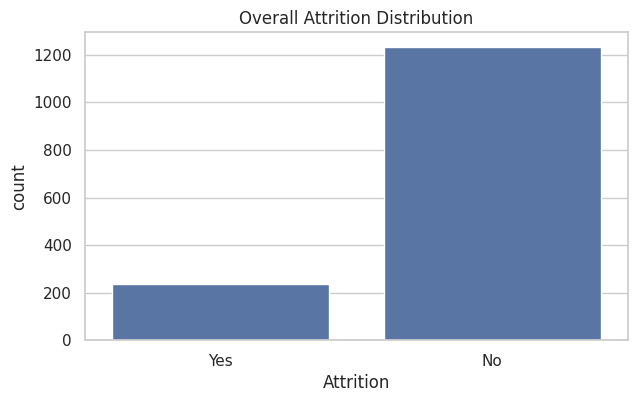

In [7]:
rate = df_eda["Attrition"].value_counts(normalize=True).mul(100).round(2)
print("Overall Attrition Rate (%):")
display(rate.to_frame("Percent"))

sns.countplot(x="Attrition", data=df_eda)
plt.title("Overall Attrition Distribution")
plt.show()


In [9]:
def percent_attrition_by(col):
    tmp = (df_eda
           .groupby(col)["Attrition_Flag"]
           .mean()
           .mul(100)
           .reset_index()
           .rename(columns={"Attrition_Flag":"Attrition_%"}))
    tmp = tmp.sort_values("Attrition_%", ascending=False)
    return tmp

def plot_percent_attrition(col, rotate=0):
    tmp = percent_attrition_by(col)
    ax = sns.barplot(data=tmp, x=col, y="Attrition_%")
    plt.title(f"% Attrition by {col}")
    plt.ylabel("% Attrition")
    plt.xlabel(col)
    if rotate:
        plt.xticks(rotation=rotate, ha="right")
    # Annotate bars
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.1f}%", (p.get_x()+p.get_width()/2, p.get_height()),
                    ha='center', va='bottom', xytext=(0,3), textcoords='offset points')
    plt.tight_layout()
    plt.show()


,AgeBand,Attrition_%
3,<30,27.914110
0,30-39,14.308682
2,50+,13.294798
1,40-49,9.742120


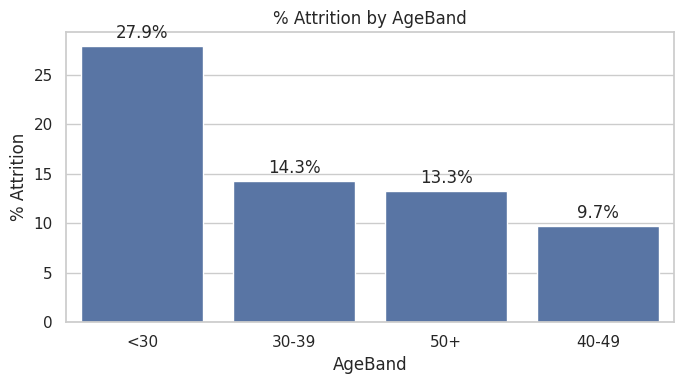

,Gender,Attrition_%
1,Male,17.006803
0,Female,14.795918


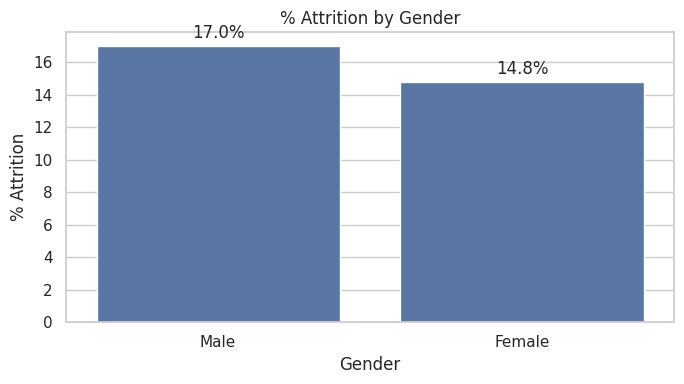

,Education_cat,Attrition_%
0,1,18.235294
2,3,17.307692
1,2,15.602837
3,4,14.572864
4,5,10.416667


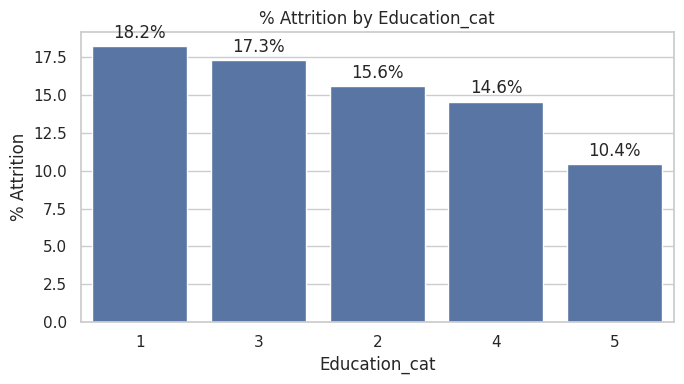

,Department,Attrition_%
2,Sales,20.627803
0,Human Resources,19.047619
1,Research & Development,13.839750


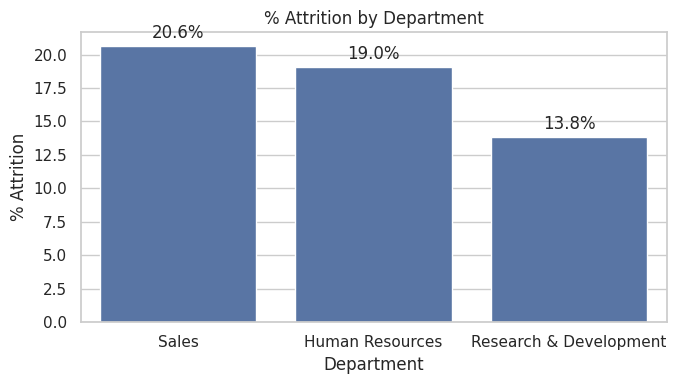

,JobRole,Attrition_%
8,Sales Representative,39.759036
2,Laboratory Technician,23.938224
1,Human Resources,23.076923
7,Sales Executive,17.484663
6,Research Scientist,16.095890
4,Manufacturing Director,6.896552
0,Healthcare Representative,6.870229
3,Manager,4.901961
5,Research Director,2.500000


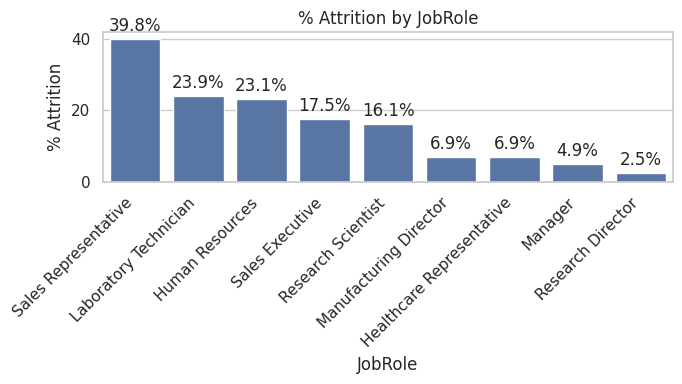

In [10]:
# Age bands
display(percent_attrition_by("AgeBand"))
plot_percent_attrition("AgeBand")

# Gender
display(percent_attrition_by("Gender"))
plot_percent_attrition("Gender")

# Education Level (ordinal coded 1-5 in this dataset but treat as category for reporting)
df_eda["Education_cat"] = df_eda["Education"].astype(str)
display(percent_attrition_by("Education_cat"))
plot_percent_attrition("Education_cat")

# Department
display(percent_attrition_by("Department"))
plot_percent_attrition("Department")

# JobRole
display(percent_attrition_by("JobRole"))
plot_percent_attrition("JobRole", rotate=45)


,OverTime,Attrition_%
1,Yes,30.528846
0,No,10.436433


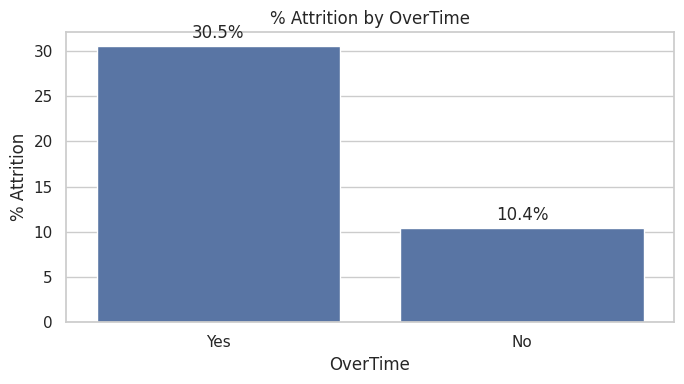

,BusinessTravel,Attrition_%
1,Travel_Frequently,24.909747
2,Travel_Rarely,14.956855
0,Non-Travel,8.000000


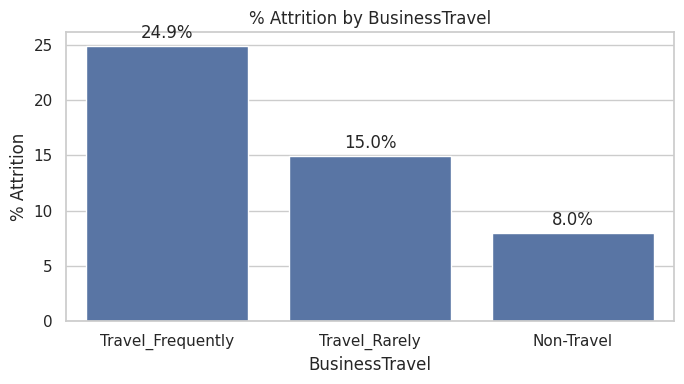

,WorkLifeBalance_cat,Attrition_%
0,1,31.250000
3,4,17.647059
1,2,16.860465
2,3,14.221725


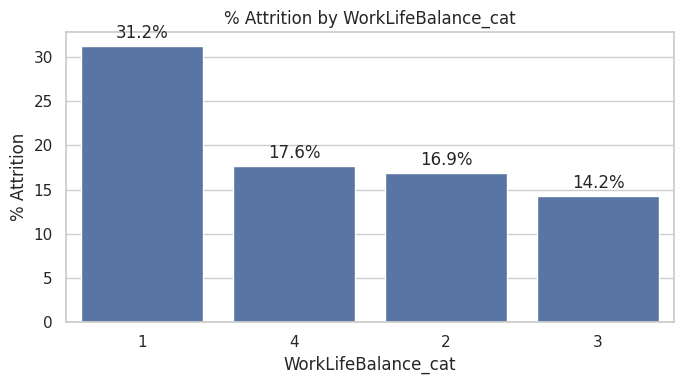

,JobInvolvement_cat,Attrition_%
0,1,33.734940
1,2,18.933333
2,3,14.400922
3,4,9.027778


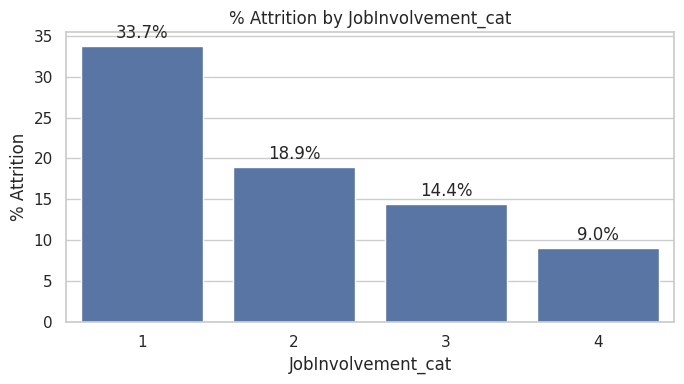

,JobSatisfaction_cat,Attrition_%
0,1,22.837370
2,3,16.515837
1,2,16.428571
3,4,11.328976


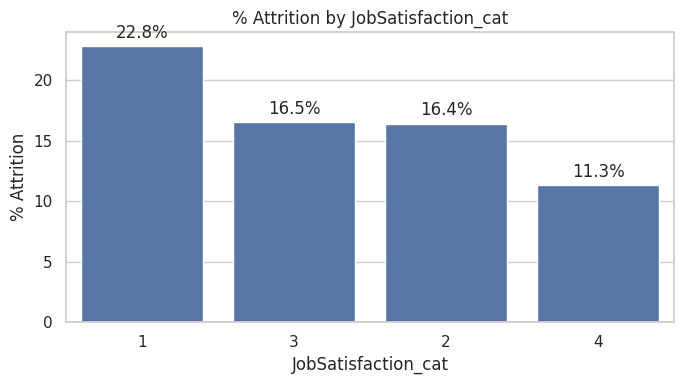

,EnvironmentSatisfaction_cat,Attrition_%
0,1,25.352113
1,2,14.982578
2,3,13.686534
3,4,13.452915


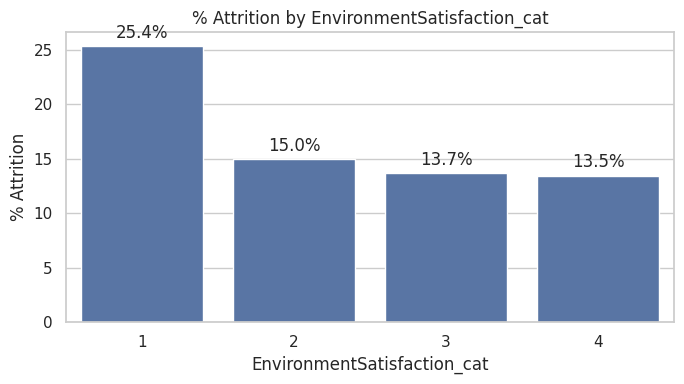

,StockOptionLevel_cat,Attrition_%
0,0,24.405705
3,3,17.647059
1,1,9.395973
2,2,7.594937


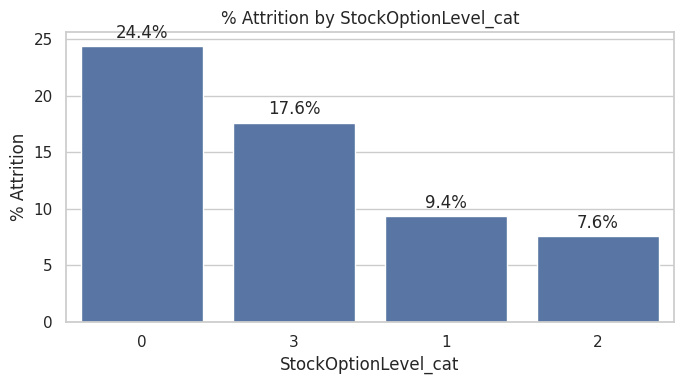

,MaritalStatus,Attrition_%
2,Single,25.531915
1,Married,12.481426
0,Divorced,10.091743


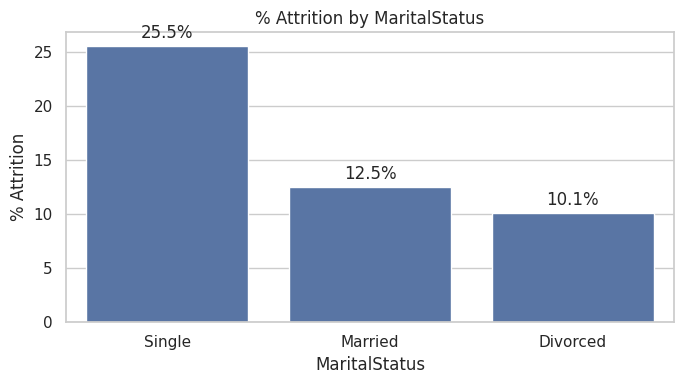

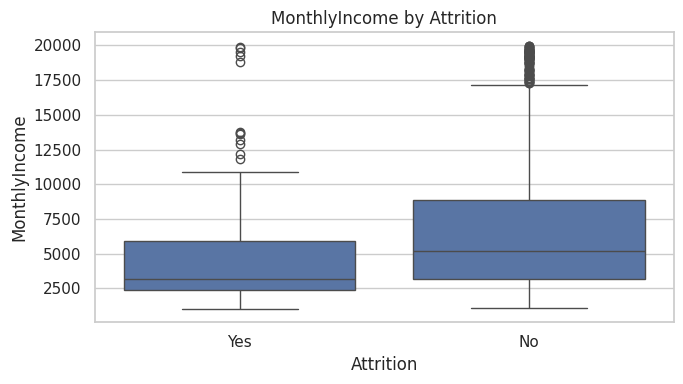

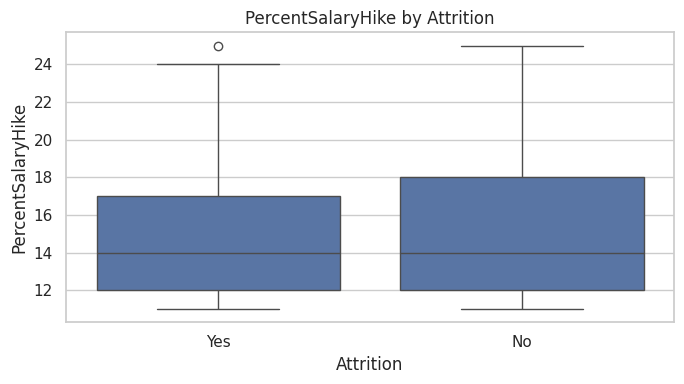

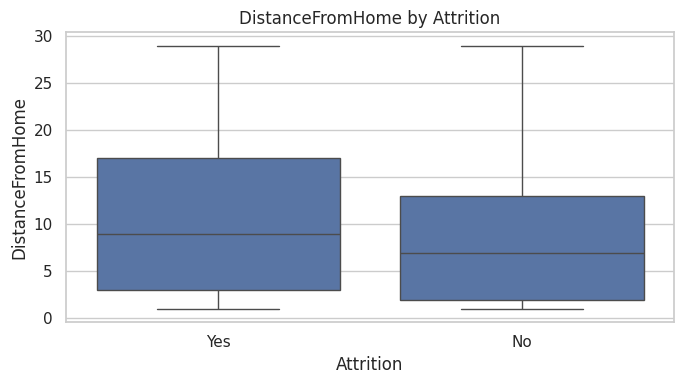

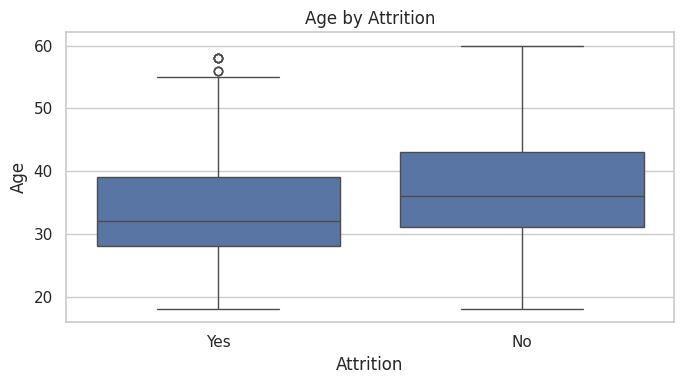

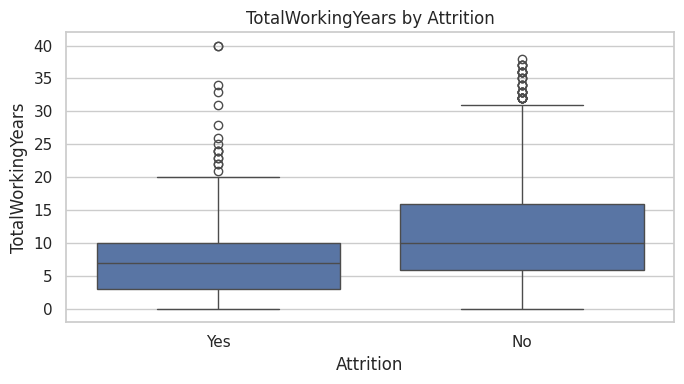

In [11]:
# Categorical drivers → % attrition bars
for col in ["OverTime", "BusinessTravel", "WorkLifeBalance", "JobInvolvement",
            "JobSatisfaction", "EnvironmentSatisfaction", "StockOptionLevel", "MaritalStatus"]:
    tmpcol = col
    if df_eda[col].dtype != 'O':
        tmpcol = f"{col}_cat"
        df_eda[tmpcol] = df_eda[col].astype(str)
    display(percent_attrition_by(tmpcol))
    plot_percent_attrition(tmpcol, rotate=0 if df_eda[tmpcol].nunique()<6 else 30)

# Numeric drivers → distributions by attrition
num_cols_to_plot = ["MonthlyIncome", "PercentSalaryHike", "DistanceFromHome", "Age", "TotalWorkingYears"]
for col in num_cols_to_plot:
    ax = sns.boxplot(data=df_eda, x="Attrition", y=col)
    plt.title(f"{col} by Attrition")
    plt.tight_layout()
    plt.show()


In [12]:
from itertools import chain

cat_vars = [
    "Gender","Department","JobRole","EducationField","BusinessTravel",
    "OverTime","MaritalStatus","WorkLifeBalance","JobInvolvement",
    "JobSatisfaction","EnvironmentSatisfaction","StockOptionLevel","AgeBand"
]

num_vars = ["MonthlyIncome","PercentSalaryHike","DistanceFromHome","Age",
            "TotalWorkingYears","YearsAtCompany","YearsInCurrentRole"]

# Chi-square for categorical vs Attrition
chi_rows = []
for c in cat_vars:
    ct = pd.crosstab(df_eda[c], df_eda["Attrition"])
    chi2, p, dof, exp = stats.chi2_contingency(ct)
    chi_rows.append({"variable": c, "chi2": chi2, "p_value": p, "dof": dof})

chi_df = pd.DataFrame(chi_rows).sort_values("p_value")
print("Chi-square tests (categorical): lower p = stronger association")
display(chi_df)

# Welch t-test for numeric vs Attrition + Cohen's d
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    vx, vy = x.var(ddof=1), y.var(ddof=1)
    pooled = ((nx-1)*vx + (ny-1)*vy) / (nx+ny-2)
    d = (x.mean() - y.mean()) / np.sqrt(pooled)
    return d

tt_rows = []
a1 = df_eda["Attrition"]=="Yes"
a0 = df_eda["Attrition"]=="No"

for c in num_vars:
    x, y = df_eda.loc[a1, c].values, df_eda.loc[a0, c].values
    t, p = stats.ttest_ind(x, y, equal_var=False)
    d = cohens_d(df_eda.loc[a1, c], df_eda.loc[a0, c])
    tt_rows.append({"variable": c, "t_stat": t, "p_value": p, "cohens_d": d})

tt_df = pd.DataFrame(tt_rows).sort_values("p_value")
print("Welch t-tests (numeric): lower p = stronger difference")
display(tt_df)


Chi-square tests (categorical): lower p = stronger association


,variable,chi2,p_value,dof
5,OverTime,87.564294,8.158424e-21,1
2,JobRole,86.190254,2.752482e-15,8
11,StockOptionLevel,60.598301,4.379390e-13,3
6,MaritalStatus,46.163677,9.455511e-11,2
12,AgeBand,46.560924,4.309418e-10,3
8,JobInvolvement,28.492021,2.863181e-06,3
4,BusinessTravel,24.182414,5.608614e-06,2
10,EnvironmentSatisfaction,22.503881,5.123469e-05,3
9,JobSatisfaction,17.505077,5.563005e-04,3
7,WorkLifeBalance,16.325097,9.725699e-04,3


Welch t-tests (numeric): lower p = stronger difference


,variable,t_stat,p_value,cohens_d
0,MonthlyIncome,-7.482622,4.433589e-13,-0.440018
4,TotalWorkingYears,-7.019179,1.159817e-11,-0.471815
6,YearsInCurrentRole,-6.847079,3.187390e-11,-0.442011
3,Age,-5.828012,1.379760e-08,-0.438225
5,YearsAtCompany,-5.282596,2.285905e-07,-0.368551
2,DistanceFromHome,2.888183,4.136512e-03,0.212401
1,PercentSalaryHike,-0.504245,6.144301e-01,-0.036630


In [13]:
# Create working copy
data = df.copy()

# Target to numeric
data["Attrition"] = data["Attrition"].map({"Yes":1, "No":0})

# Drop ID/constant columns if present
drop_cols = [c for c in ["EmployeeNumber","EmployeeCount","Over18","StandardHours"] if c in data.columns]
data = data.drop(columns=drop_cols)

# Identify column types
cat_cols = data.select_dtypes(include=["object"]).columns.tolist()
num_cols = data.select_dtypes(include=["int64","float64","int32","float32","int16"]).drop("Attrition", axis=1).columns.tolist()

print("Categorical cols:", cat_cols)
print("Numeric cols:", num_cols)
print("Target balance:\n", data["Attrition"].value_counts(normalize=True).mul(100).round(2))

# Split
X = data.drop("Attrition", axis=1)
y = data["Attrition"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop=None, handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop"
)


Categorical cols: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
Numeric cols: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
Target balance:
 Attrition
0    83.88
1    16.12
Name: proportion, dtype: float64


5-fold CV (Logistic + SMOTE): mean ± std
 accuracy: 0.779 ± 0.023
precision: 0.401 ± 0.029
   recall: 0.716 ± 0.056
       f1: 0.512 ± 0.015
  roc_auc: 0.830 ± 0.026
   pr_auc: 0.601 ± 0.067

Test ROC-AUC: 0.796

Classification Report (Logistic):
               precision    recall  f1-score   support

           0      0.908     0.802     0.852       247
           1      0.355     0.574     0.439        47

    accuracy                          0.765       294
   macro avg      0.632     0.688     0.645       294
weighted avg      0.820     0.765     0.786       294



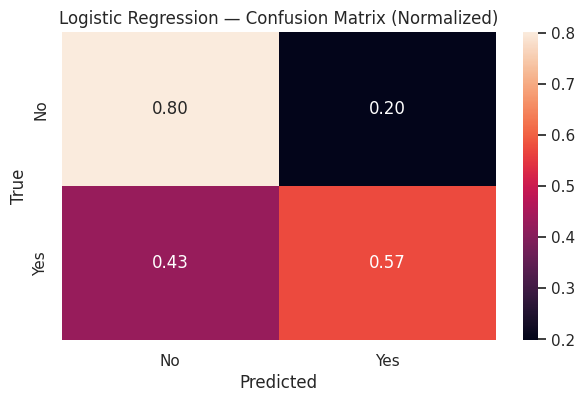

In [14]:
logit_pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("clf", LogisticRegression(max_iter=2000))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {
    "accuracy":"accuracy",
    "precision":"precision",
    "recall":"recall",
    "f1":"f1",
    "roc_auc":"roc_auc",
    "pr_auc":"average_precision"
}

cv_res = cross_validate(logit_pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
cv_summary = {k: (np.mean(v), np.std(v)) for k,v in cv_res.items() if k.startswith("test_")}
print("5-fold CV (Logistic + SMOTE): mean ± std")
for k,(m,s) in cv_summary.items():
    print(f"{k.replace('test_',''):>9}: {m:.3f} ± {s:.3f}")

# Fit on full train, evaluate on test
logit_pipe.fit(X_train, y_train)
proba = logit_pipe.predict_proba(X_test)[:,1]
pred  = (proba >= 0.5).astype(int)

print("\nTest ROC-AUC:", roc_auc_score(y_test, proba).round(3))
print("\nClassification Report (Logistic):\n", classification_report(y_test, pred, digits=3))

# Confusion matrix (normalized)
cm = confusion_matrix(y_test, pred, normalize='true')
sns.heatmap(cm, annot=True, fmt=".2f", xticklabels=["No","Yes"], yticklabels=["No","Yes"])
plt.title("Logistic Regression — Confusion Matrix (Normalized)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()


5-fold CV (RandomForest + SMOTE): mean ± std
 accuracy: 0.869 ± 0.006
precision: 0.738 ± 0.064
   recall: 0.316 ± 0.100
       f1: 0.428 ± 0.086
  roc_auc: 0.819 ± 0.037
   pr_auc: 0.592 ± 0.053

Test ROC-AUC (RF): 0.798

Classification Report (Random Forest):
               precision    recall  f1-score   support

           0      0.872     0.964     0.915       247
           1      0.571     0.255     0.353        47

    accuracy                          0.850       294
   macro avg      0.722     0.609     0.634       294
weighted avg      0.824     0.850     0.825       294



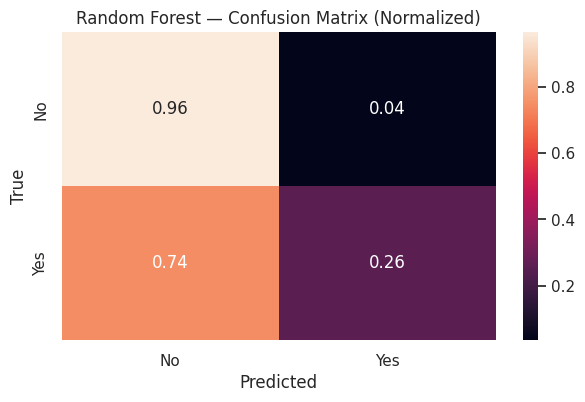

In [15]:
rf_pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("clf", RandomForestClassifier(
        n_estimators=400, max_depth=None, min_samples_split=4,
        n_jobs=-1, random_state=RANDOM_STATE
    ))
])

cv_res_rf = cross_validate(rf_pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
cv_summary_rf = {k: (np.mean(v), np.std(v)) for k,v in cv_res_rf.items() if k.startswith("test_")}
print("5-fold CV (RandomForest + SMOTE): mean ± std")
for k,(m,s) in cv_summary_rf.items():
    print(f"{k.replace('test_',''):>9}: {m:.3f} ± {s:.3f}")

rf_pipe.fit(X_train, y_train)
proba_rf = rf_pipe.predict_proba(X_test)[:,1]
pred_rf  = (proba_rf >= 0.5).astype(int)

print("\nTest ROC-AUC (RF):", roc_auc_score(y_test, proba_rf).round(3))
print("\nClassification Report (Random Forest):\n", classification_report(y_test, pred_rf, digits=3))

cm_rf = confusion_matrix(y_test, pred_rf, normalize='true')
sns.heatmap(cm_rf, annot=True, fmt=".2f", xticklabels=["No","Yes"], yticklabels=["No","Yes"])
plt.title("Random Forest — Confusion Matrix (Normalized)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()


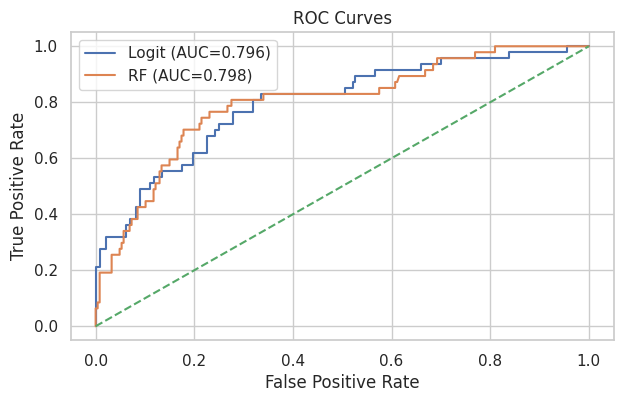

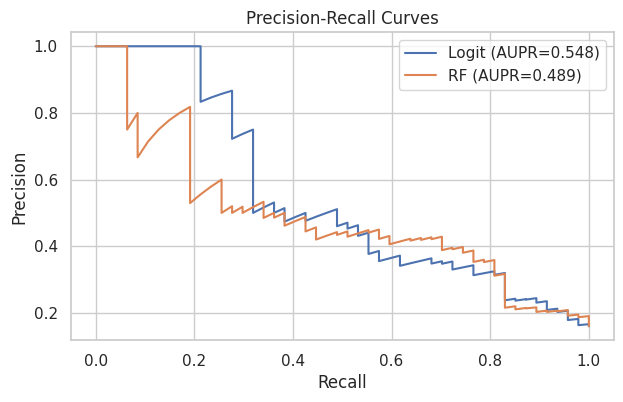

In [16]:
# Logistic
fpr_l, tpr_l, _ = roc_curve(y_test, proba)
prec_l, rec_l, _ = precision_recall_curve(y_test, proba)
aupr_l = average_precision_score(y_test, proba)

# RF
fpr_r, tpr_r, _ = roc_curve(y_test, proba_rf)
prec_r, rec_r, _ = precision_recall_curve(y_test, proba_rf)
aupr_r = average_precision_score(y_test, proba_rf)

# ROC
plt.plot(fpr_l, tpr_l, label=f"Logit (AUC={roc_auc_score(y_test, proba):.3f})")
plt.plot(fpr_r, tpr_r, label=f"RF (AUC={roc_auc_score(y_test, proba_rf):.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(); plt.show()

# PR
plt.plot(rec_l, prec_l, label=f"Logit (AUPR={aupr_l:.3f})")
plt.plot(rec_r, prec_r, label=f"RF (AUPR={aupr_r:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend(); plt.show()


,importance
OverTime_Yes,0.074903
OverTime_No,0.070121
StockOptionLevel,0.055813
JobLevel,0.052349
MaritalStatus_Single,0.040147
Age,0.036659
TotalWorkingYears,0.035893
YearsAtCompany,0.035018
MonthlyIncome,0.034280
YearsWithCurrManager,0.033802


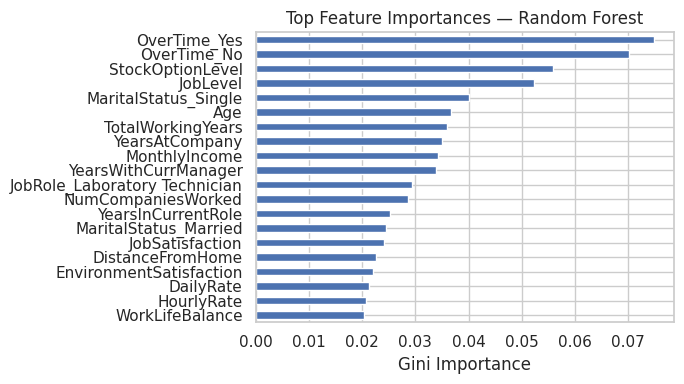

In [17]:
# Get feature names after preprocessing
ohe = rf_pipe.named_steps["prep"].named_transformers_["cat"]
num_names = rf_pipe.named_steps["prep"].transformers_[0][2]
cat_names = ohe.get_feature_names_out(input_features=rf_pipe.named_steps["prep"].transformers_[1][2])
feat_names = np.r_[num_names, cat_names]

rf = rf_pipe.named_steps["clf"]
importances = pd.Series(rf.feature_importances_, index=feat_names).sort_values(ascending=False)

topN = 20
display(importances.head(topN).to_frame("importance"))

ax = importances.head(topN).iloc[::-1].plot(kind="barh")
plt.title("Top Feature Importances — Random Forest")
plt.xlabel("Gini Importance")
plt.tight_layout()
plt.show()


Top 15 (by absolute coefficient):


,coef,odds_ratio,abs_coef
JobRole_Research Director,-2.000220,0.135305,2.000220
JobRole_Laboratory Technician,1.495614,4.462074,1.495614
JobRole_Sales Representative,1.250177,3.490960,1.250177
BusinessTravel_Non-Travel,-1.247575,0.287200,1.247575
EducationField_Human Resources,1.100599,3.005965,1.100599
EducationField_Other,-1.087972,0.336899,1.087972
OverTime_No,-1.035947,0.354890,1.035947
BusinessTravel_Travel_Frequently,0.885394,2.423940,0.885394
OverTime_Yes,0.828357,2.289555,0.828357
TotalWorkingYears,-0.790663,0.453544,0.790663


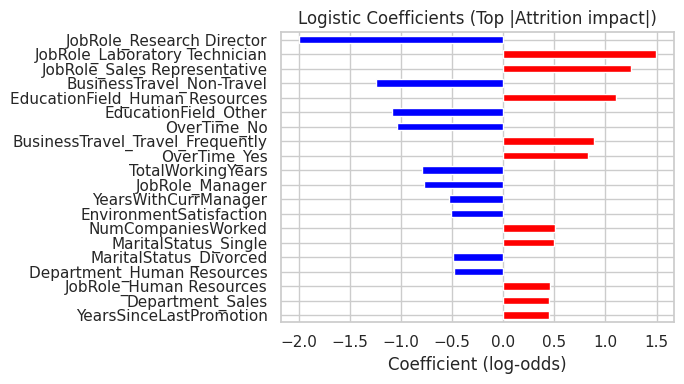

In [18]:
# Retrieve trained logistic model on test-fit pipeline
log_model = logit_pipe.named_steps["clf"]
ohe = logit_pipe.named_steps["prep"].named_transformers_["cat"]
num_names = logit_pipe.named_steps["prep"].transformers_[0][2]
cat_names = ohe.get_feature_names_out(input_features=logit_pipe.named_steps["prep"].transformers_[1][2])
feat_names = np.r_[num_names, cat_names]

coefs = pd.Series(log_model.coef_.ravel(), index=feat_names)
odds = np.exp(coefs)  # >1 increases attrition odds; <1 decreases
coef_df = pd.DataFrame({"coef": coefs, "odds_ratio": odds, "abs_coef": coefs.abs()}).sort_values("abs_coef", ascending=False)

print("Top 15 (by absolute coefficient):")
display(coef_df.head(15))

# Visualize sign & magnitude
top = coef_df.head(20).copy()
colors = top["coef"].apply(lambda x: "red" if x>0 else "blue")
top[::-1]["coef"].plot(kind="barh", color=colors[::-1])
plt.title("Logistic Coefficients (Top |Attrition impact|)")
plt.xlabel("Coefficient (log-odds)")
plt.tight_layout()
plt.show()


In [19]:
summary_points = []

# Overall rate
overall = df_eda["Attrition_Flag"].mean()*100
summary_points.append(f"Overall attrition rate ≈ {overall:.1f}%.")

# Top 5 RF features
top5_rf = importances.head(5).index.tolist()
summary_points.append("Top RF predictors: " + ", ".join(top5_rf) + ".")

# Strongest positive/negative drivers from logistic
pos = coef_df[coef_df.coef>0].head(3).index.tolist()
neg = coef_df[coef_df.coef<0].head(3).index.tolist()
summary_points.append("Logistic (↑ risk): " + ", ".join(pos) + ".")
summary_points.append("Logistic (↓ risk): " + ", ".join(neg) + ".")

# Key categorical signals (use chi-square ordering)
summary_points.append("Strong categorical associations (chi-square): " + ", ".join(chi_df.head(5)["variable"]) + ".")

print("\n".join(f"- {s}" for s in summary_points))


- Overall attrition rate ≈ 16.1%.
- Top RF predictors: OverTime_Yes, OverTime_No, StockOptionLevel, JobLevel, MaritalStatus_Single.
- Logistic (↑ risk): JobRole_Laboratory Technician, JobRole_Sales Representative, EducationField_Human Resources.
- Logistic (↓ risk): JobRole_Research Director, BusinessTravel_Non-Travel, EducationField_Other.
- Strong categorical associations (chi-square): OverTime, JobRole, StockOptionLevel, MaritalStatus, AgeBand.
